# Create a Spatiotemporal Pyramid Based on the Adelson & Bergen Spatiotemporal Energy Model
See the adelsonbergen1984 Notebook for background

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.signal as signal

In [195]:
def spatial_filter_1d(x, order=2, sigma=1):
    if order == 2:
        #second derivative of gaussian
        response = - 1/(np.sqrt(2*np.pi)*sigma**5) * (-sigma**2+x**2) * np.exp(-x**2/(2*sigma**2))
        #response = -(np.exp(-(x**2/2))*(-1+x)*(1+x))/np.sqrt(2*np.pi)
    elif order == 3:
        #third derivative of gaussian
        response = 1/(np.sqrt(2*np.pi)*sigma**7) * (3*x*sigma**2-x**3) * np.exp(-x**2/(2*sigma**2))
        #response = (np.exp(-(x**2/2))*x*(-3+x**2))/np.sqrt(2*np.pi)
    else:
        print('Must be 2nd or 3rd order!')
        return
    return response


#gaussian Spatial Filter per Adelson & Bergen, 2nd and 3rd derivatives of Gaussian
def spatial_filter_2d(x1, x2, sigma=1, order=2, oriented=False):
    if oriented:
        print('Oriented Not Yet Implmented')
        return
    else:
        if order == 2:
            #second derivative of gaussian
            x1_response = -1/(np.sqrt(2*np.pi)*sigma**5) * (-sigma**2+x1**2) * np.exp(-x1**2/(2*sigma**2))
            x2_response = -1/(np.sqrt(2*np.pi)*sigma**5) * (-sigma**2+x2**2) * np.exp(-x2**2/(2*sigma**2))
        elif order == 3:
            #third derivative of gaussian
            x1_response = 1/(np.sqrt(2*np.pi)*sigma**7) * (3*x1*sigma**2-x1**3) * np.exp(-x1**2/(2*sigma**2))
            x2_response = 1/(np.sqrt(2*np.pi)*sigma**7) * (3*x2*sigma**2-x2**3) * np.exp(-x2**2/(2*sigma**2))
        else:
            print('Must be 2nd or 3rd order!')
            return
    return x1_response * x2_response
    
#Temporal Filter per Adelson & Bergen (eq 1)
def temporal_filter(t, n=3, k=1):
    a = (k*t)**n
    b = np.exp(-k*t)
    c = (1/np.math.factorial(n))-((k*t)**2)/(np.math.factorial(n+2))
    return(a*b*c)

#combine the above for a spatiotempral filter
def spatiotemporal_filter(x,t, temporal_n=3, temporal_k=1, spatial_order=2, sigma=1):
    #spatial component
    if spatial_order == 2:
        #second derivative of gaussian
        spatial_response = - 1/(np.sqrt(2*np.pi)*sigma**5) * (-sigma**2+x**2) * np.exp(-x**2/(2*sigma**2))
    elif spatial_order == 3:
        #third derivative of gaussian
        spatial_response = 1/(np.sqrt(2*np.pi)*sigma**7) * (3*x*sigma**2-x**3) * np.exp(-x**2/(2*sigma**2))
    else:
        print('Must be 2nd or 3rd order!')
        return

    #temporal component
    a = (temporal_k*t)**temporal_n
    b = np.exp(-temporal_k*t)
    c = (1/np.math.factorial(temporal_n))-((temporal_k*t)**2)/(np.math.factorial(temporal_n+2))
    temporal_response = a*b*c

    #combine two
    response = spatial_response * temporal_response
    
    return response

### How do these filters appear in spatial/frequency space? 

Extending the paper, we wish to understand how to use these filters to create a scale-able pyramid. Our temporal filers have a temporal scale parameter, k. The spatial filers are also easily scale-able.    


In [220]:
#function to create our filters    
def build_4_filters(x,t, temporal_scale=1, spatial_scale=1):

    sg,tg = np.meshgrid(x,t)

    #create separable filters
    a = spatiotemporal_filter(sg,tg, temporal_k=temporal_scale, temporal_n=3, spatial_order=2, sigma=spatial_scale)
    ap = spatiotemporal_filter(sg,tg, temporal_k=temporal_scale, temporal_n=5, spatial_order=2, sigma=spatial_scale)
    b = spatiotemporal_filter(sg,tg, temporal_k=temporal_scale, temporal_n=3, spatial_order=3, sigma=spatial_scale)
    bp = spatiotemporal_filter(sg,tg, temporal_k=temporal_scale, temporal_n=5, spatial_order=3, sigma=spatial_scale)

    #create direcitonal filters
    a_plus_bp = a + bp
    b_minus_ap = b - ap
    bp_minus_a = bp - a
    ap_plus_b = ap + b
    
    #transpose them so time in on the y axis
    filters = [a_plus_bp,b_minus_ap,bp_minus_a,ap_plus_b]

    return(filters)

#function to calculate the power spectrum of them
def calc_power_spec(filter):
    power_spec = np.abs(np.fft.fftshift(np.fft.fft2(filter)))**2
    fqspace = np.fft.fftshift(np.fft.fftfreq(filter.shape[0],d=2))
    fqtime = np.fft.fftshift(np.fft.fftfreq(filter.shape[1],d=2))
    return(power_spec,fqspace,fqtime)

# Experiment with Effect of Spatial Scale
Adjsut Spatial Scale with $\sigma$ in the Gausian Derivative Equations: 

Second Order:
$$
\frac{1}{\sqrt{2\pi}\sigma^5}(-\sigma^2+x^2)e^{-x^2/2\sigma^2}  
%-(e^{-(x^2/2))*(-1+x)*(1+x)),\sqrt{2*\pi}}
$$
Third Order:
$$
\frac{1}{\sqrt{2\pi}\sigma^7}(3x\sigma^2-x^3)e^{-x^2/2\sigma^2}  
%(e^{-(x^2/2))*x*(-3+x**2)),\sqrt{2*\pi}}
$$

Spatial Scale:  0.5
Temporal Scale:  2


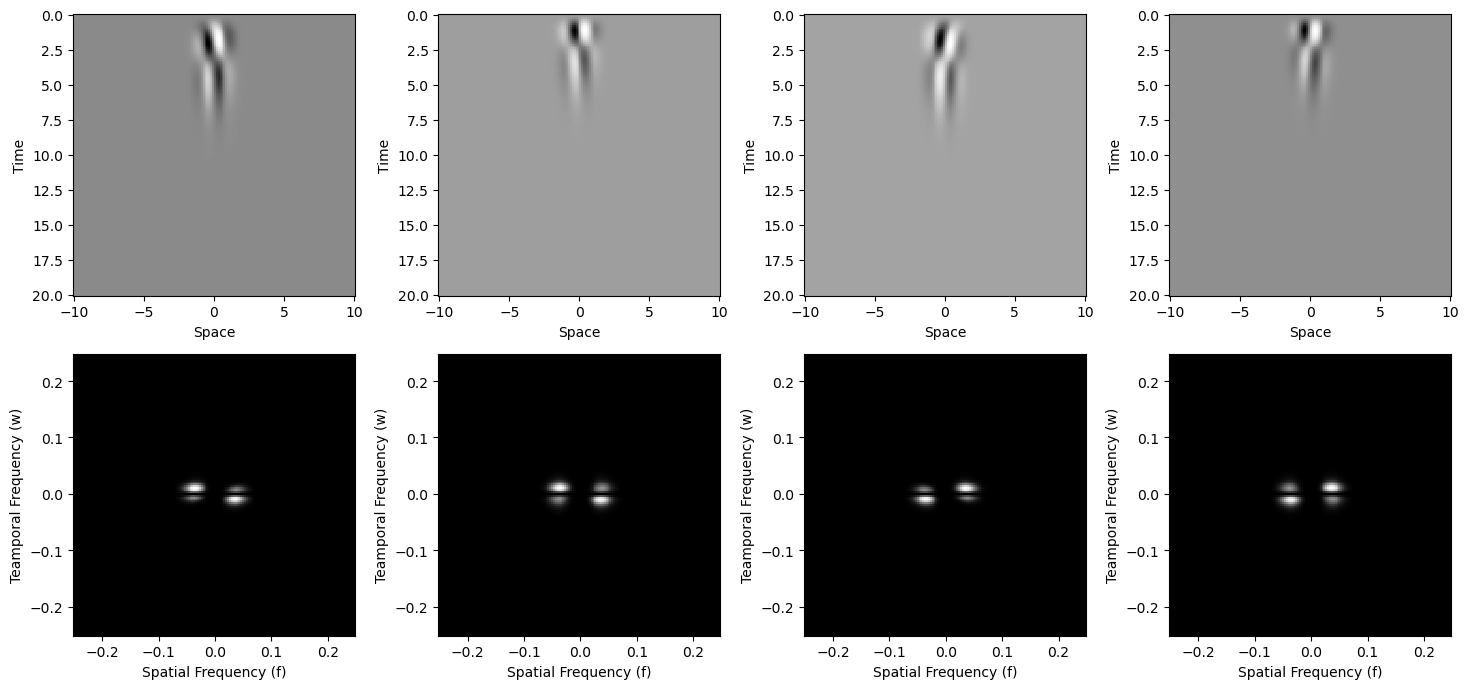

Spatial Scale:  1
Temporal Scale:  2


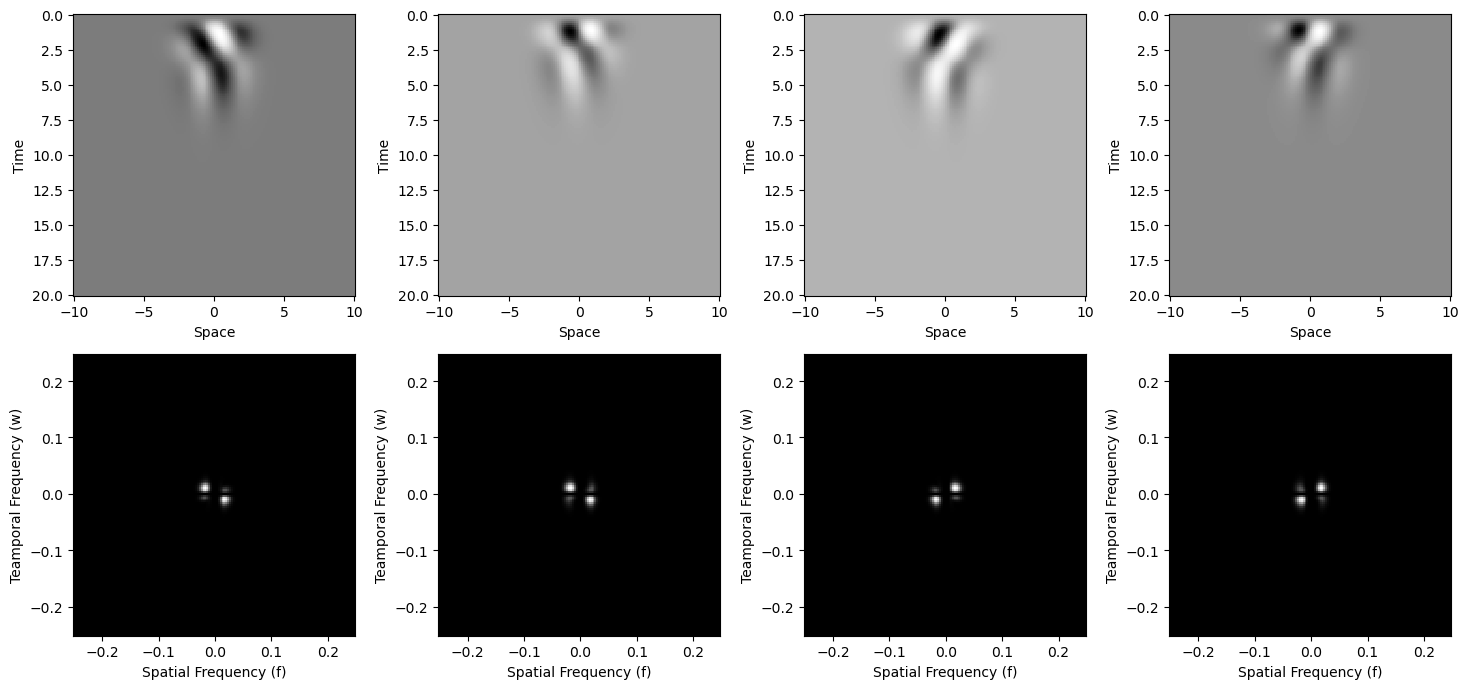

Spatial Scale:  2
Temporal Scale:  2


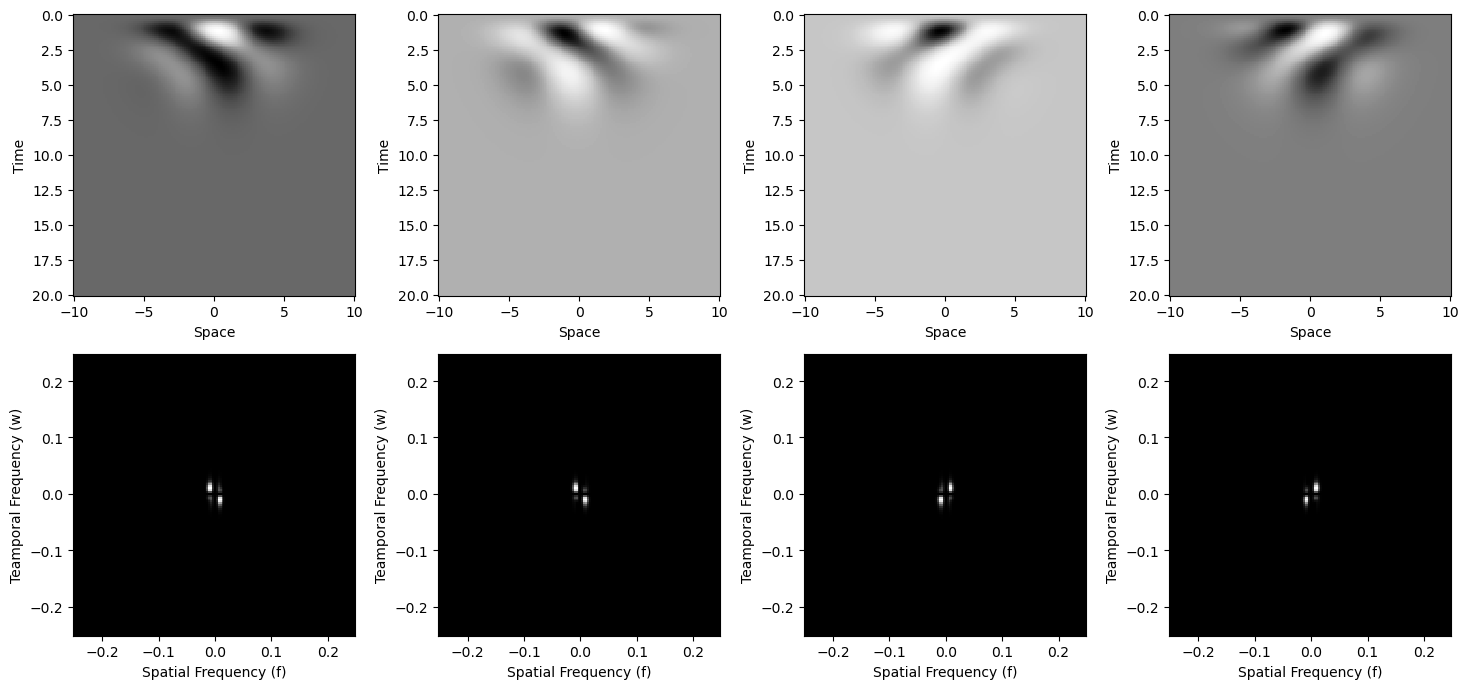

In [228]:
#setup space and time progression
space = np.linspace(-10,10,num=150)
time = np.linspace(0,20,num=150)

#pick our scales
spatial_scale=1
temporal_scale=2

for spatial_scale in [0.5,1,2]:
    print("Spatial Scale: ",spatial_scale)
    print("Temporal Scale: ",temporal_scale)
    
    #call our builder
    filters = build_4_filters(space,time,temporal_scale=temporal_scale,spatial_scale=spatial_scale)
    
    pspecs = [calc_power_spec(f)[0] for f in filters]
    _, fqspace, fqtime = calc_power_spec(filters[0])
    
    plt.figure(figsize=(15,7))
    
    for i in range(len(filters)):
        plt.subplot(2,len(filters),i+1, aspect=aspect_ratio)
        plt.pcolormesh(space, time, filters[i], shading='auto',cmap='Greys_r')
        plt.gca().invert_yaxis()
        plt.xlabel('Space')
        plt.ylabel('Time')
    
        plt.subplot(2,len(filters),i+1+len(filters), aspect=aspect_ratio)
        plt.pcolormesh(fqspace, fqtime, pspecs[i], shading='auto',cmap='Greys_r')
        plt.xlabel('Spatial Frequency (f)')
        plt.ylabel('Teamporal Frequency (w)')
        plt.tight_layout()
        
    plt.show()

# Experiment with Effect of Temporal Scale
Assume that Temporal Scale is mediated by 'k' in eq 1 from Adelson & Bergen:
$$
f(t) = (kt)^n exp(-kt)[1/n! - (kt)2 /(n + 2)!]
$$

Temporal Scale:  2
Spatial Scale:  1


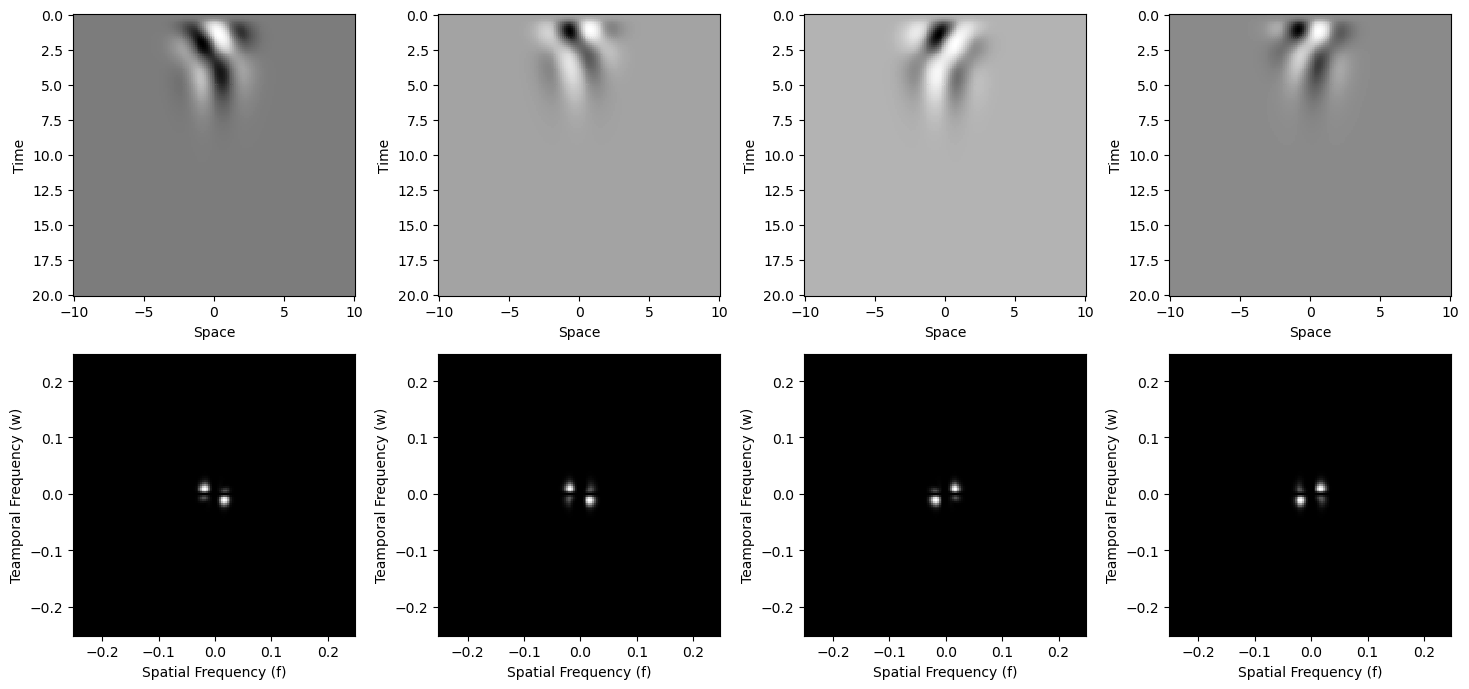

Temporal Scale:  4
Spatial Scale:  1


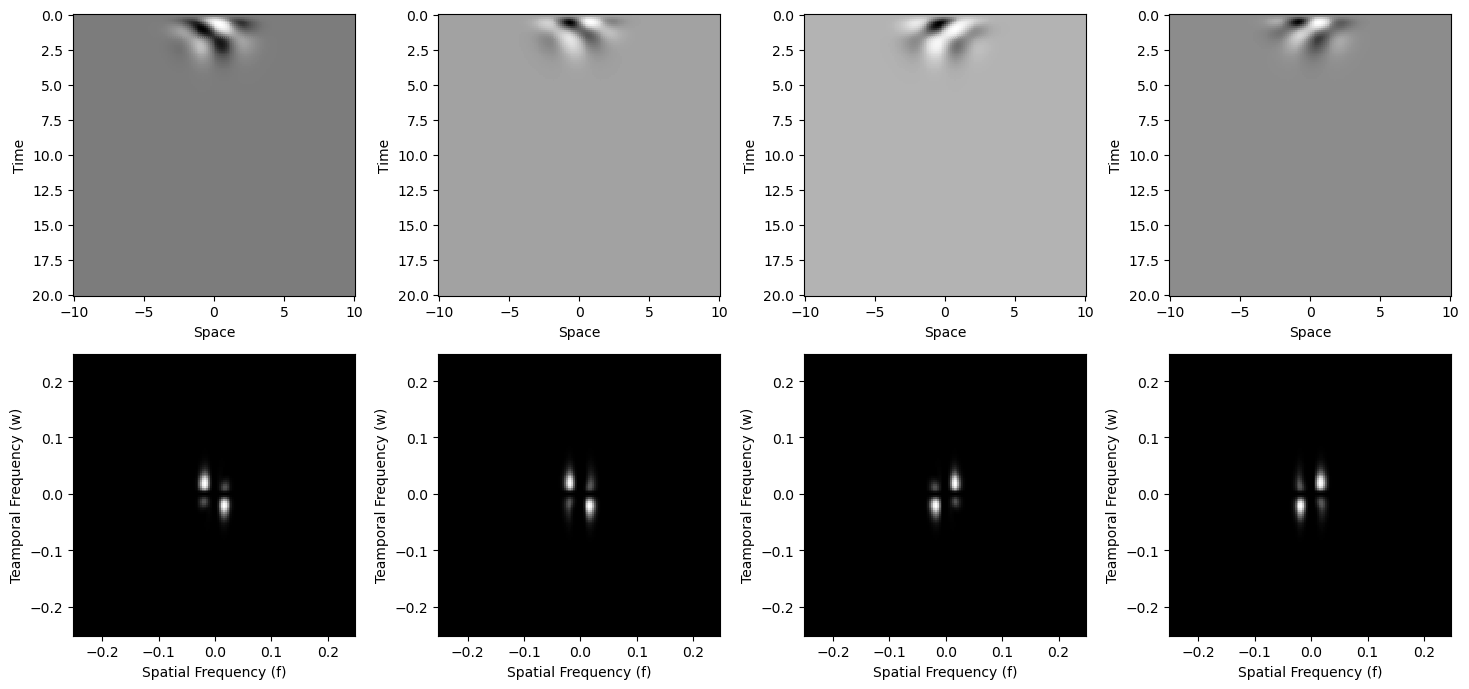

Temporal Scale:  8
Spatial Scale:  1


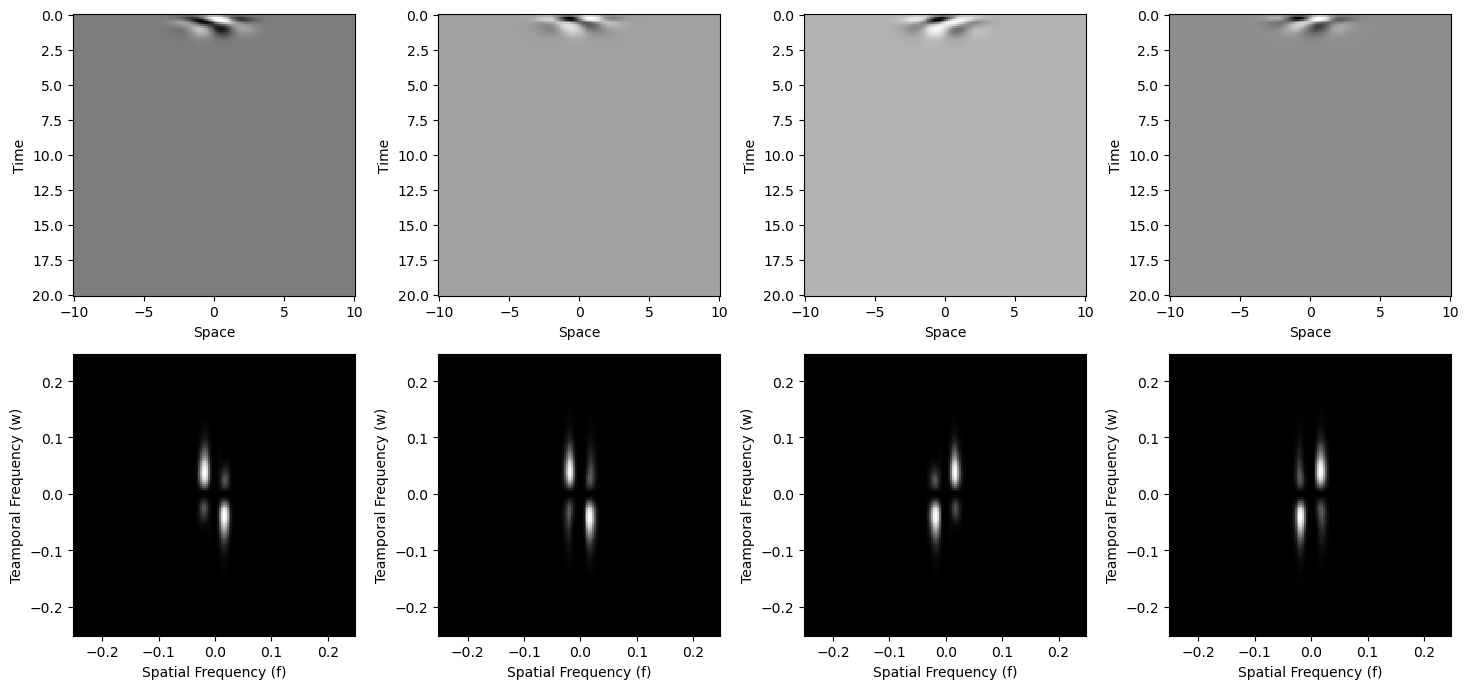

Temporal Scale:  16
Spatial Scale:  1


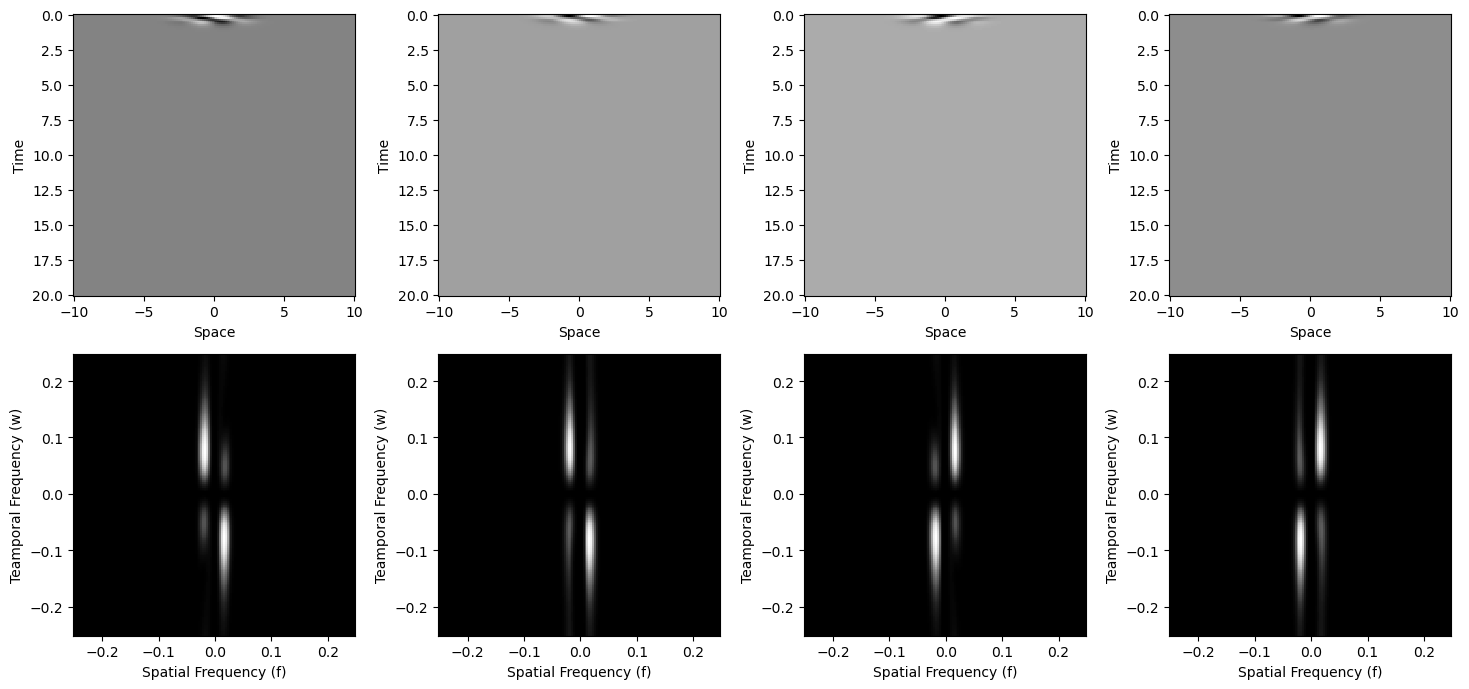

In [229]:
spatial_scale=1
for temporal_scale in [2,4,8,16]:
    print("Temporal Scale: ",temporal_scale)
    print("Spatial Scale: ",spatial_scale)
    
    #call our builder
    filters = build_4_filters(space,time,temporal_scale=temporal_scale,spatial_scale=spatial_scale)
    
    pspecs = [calc_power_spec(f)[0] for f in filters]
    _, fqspace, fqtime = calc_power_spec(filters[0])
    
    plt.figure(figsize=(15,7))
    
    for i in range(len(filters)):
        plt.subplot(2,len(filters),i+1, aspect=aspect_ratio)
        plt.pcolor(space, time, filters[i], shading='auto',cmap='Greys_r')
        plt.gca().invert_yaxis()
        plt.xlabel('Space')
        plt.ylabel('Time')
    
        plt.subplot(2,len(filters),i+1+len(filters), aspect=aspect_ratio)
        plt.pcolor(fqspace, fqtime, pspecs[i], shading='auto',cmap='Greys_r')
        plt.xlabel('Spatial Frequency (f)')
        plt.ylabel('Teamporal Frequency (w)')
        plt.tight_layout()
        
    plt.show()

In [223]:
#vary both together

spatial Scale,  0.25
Temporal Scale:  2


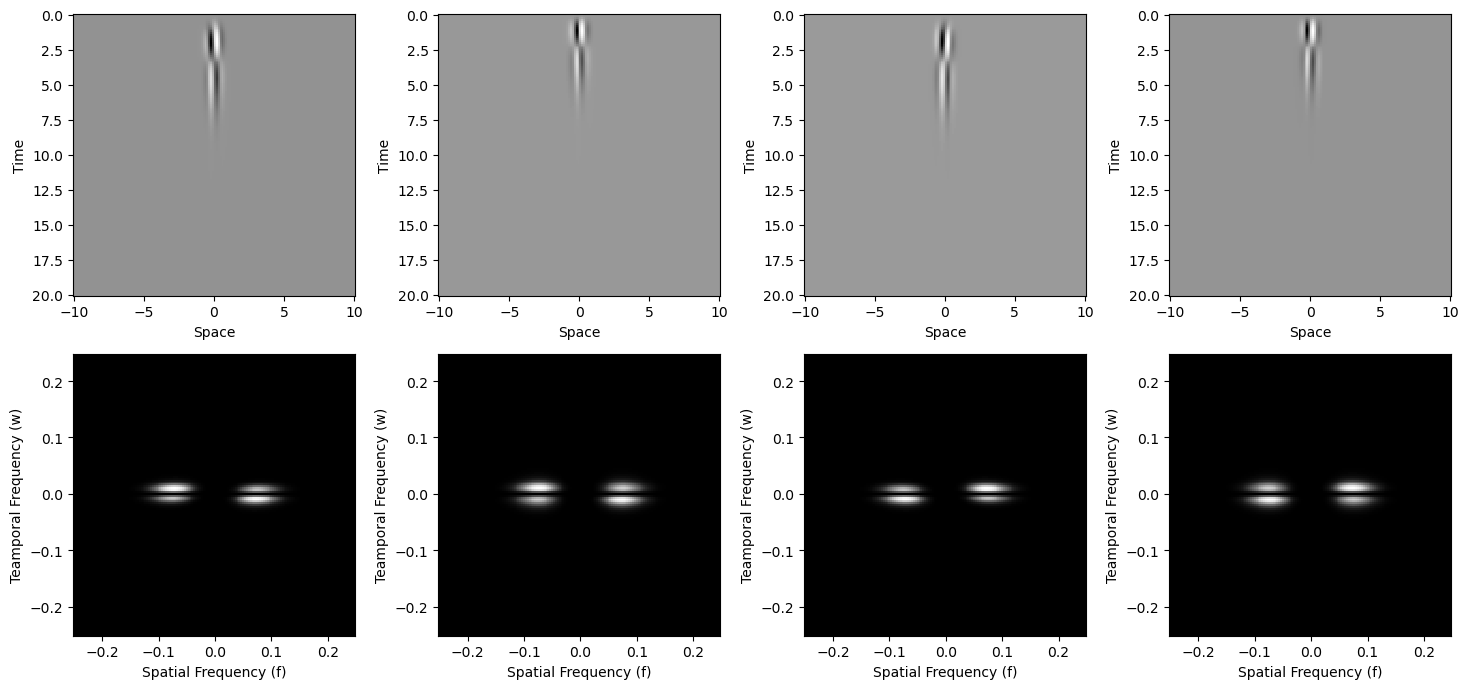

spatial Scale,  0.25
Temporal Scale:  4


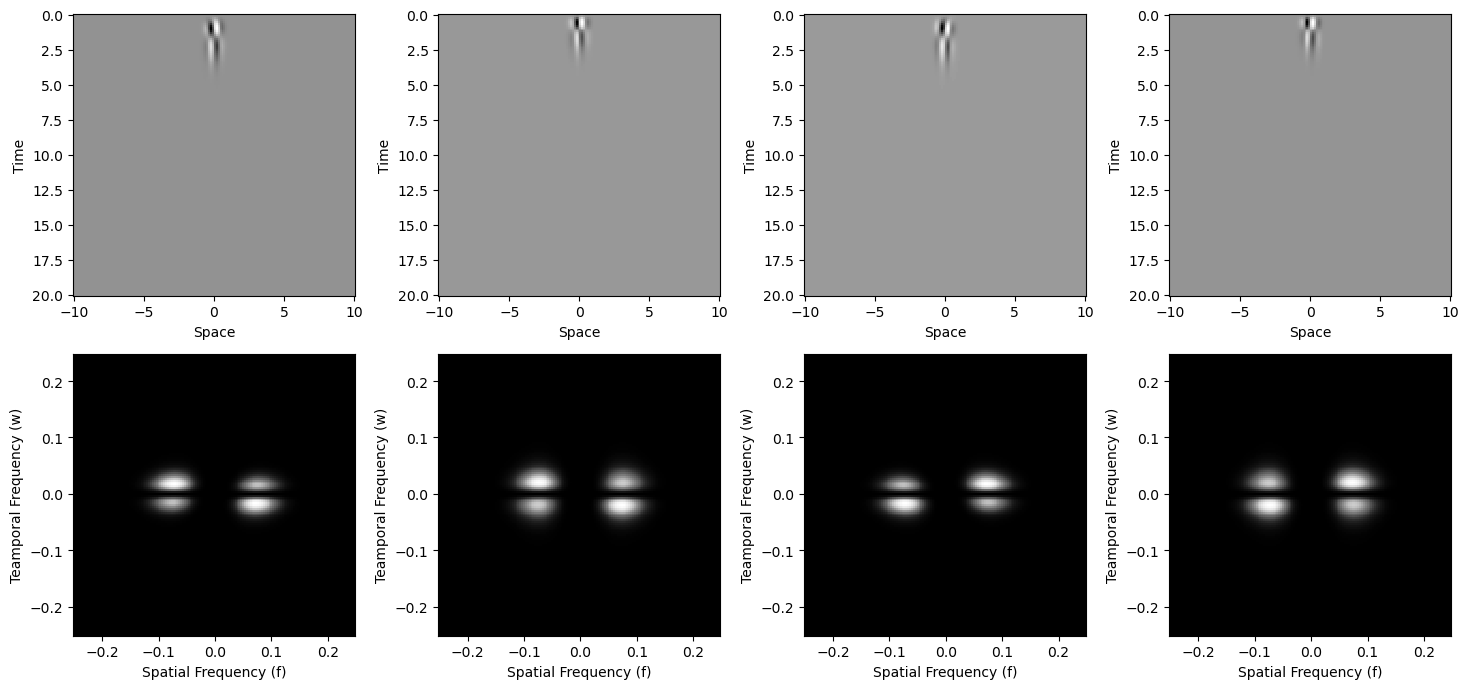

spatial Scale,  0.25
Temporal Scale:  8


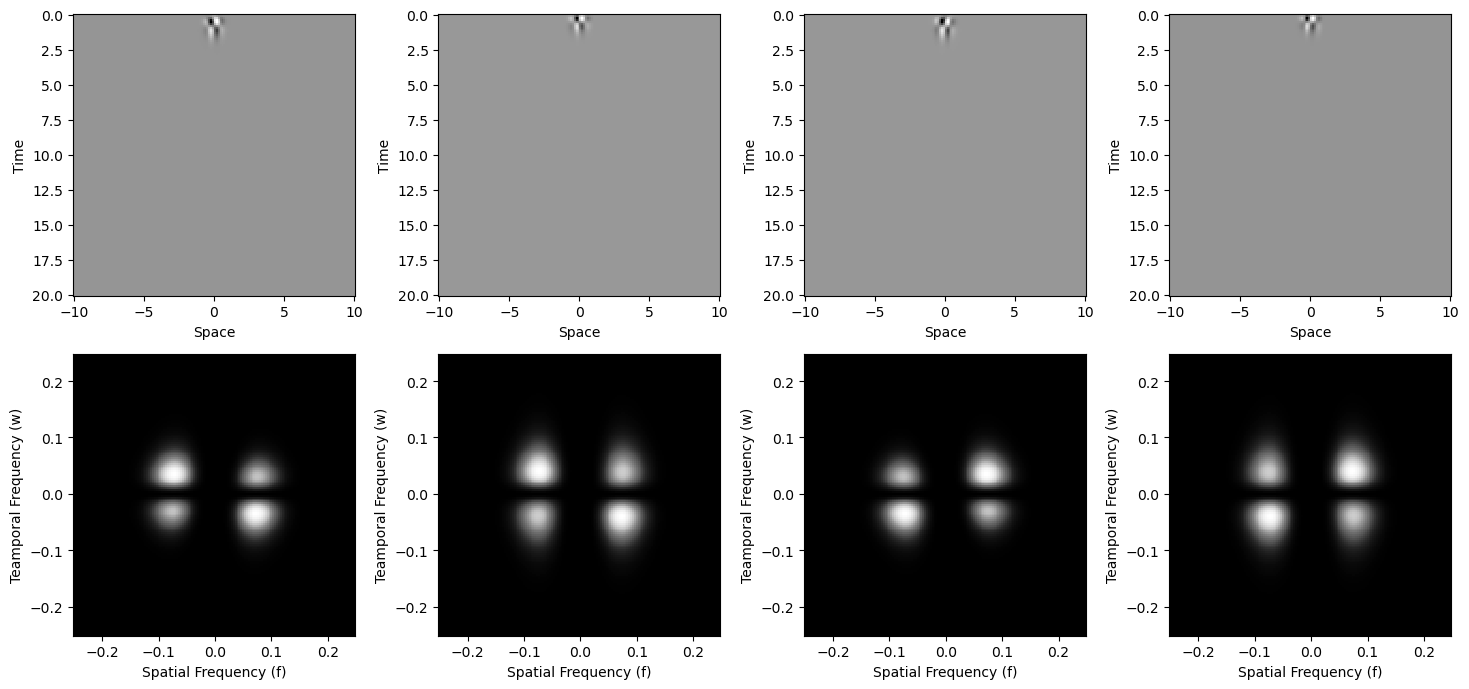

spatial Scale,  0.25
Temporal Scale:  16


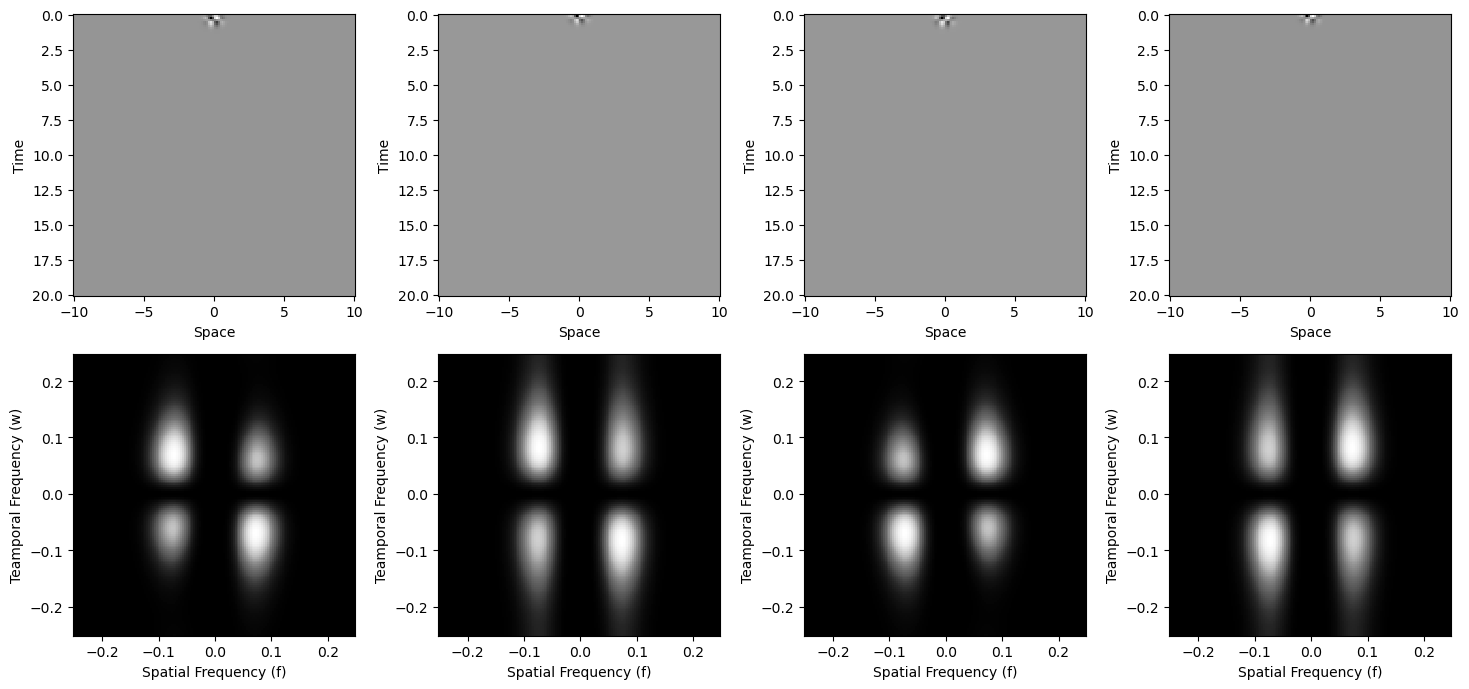

spatial Scale,  0.5
Temporal Scale:  2


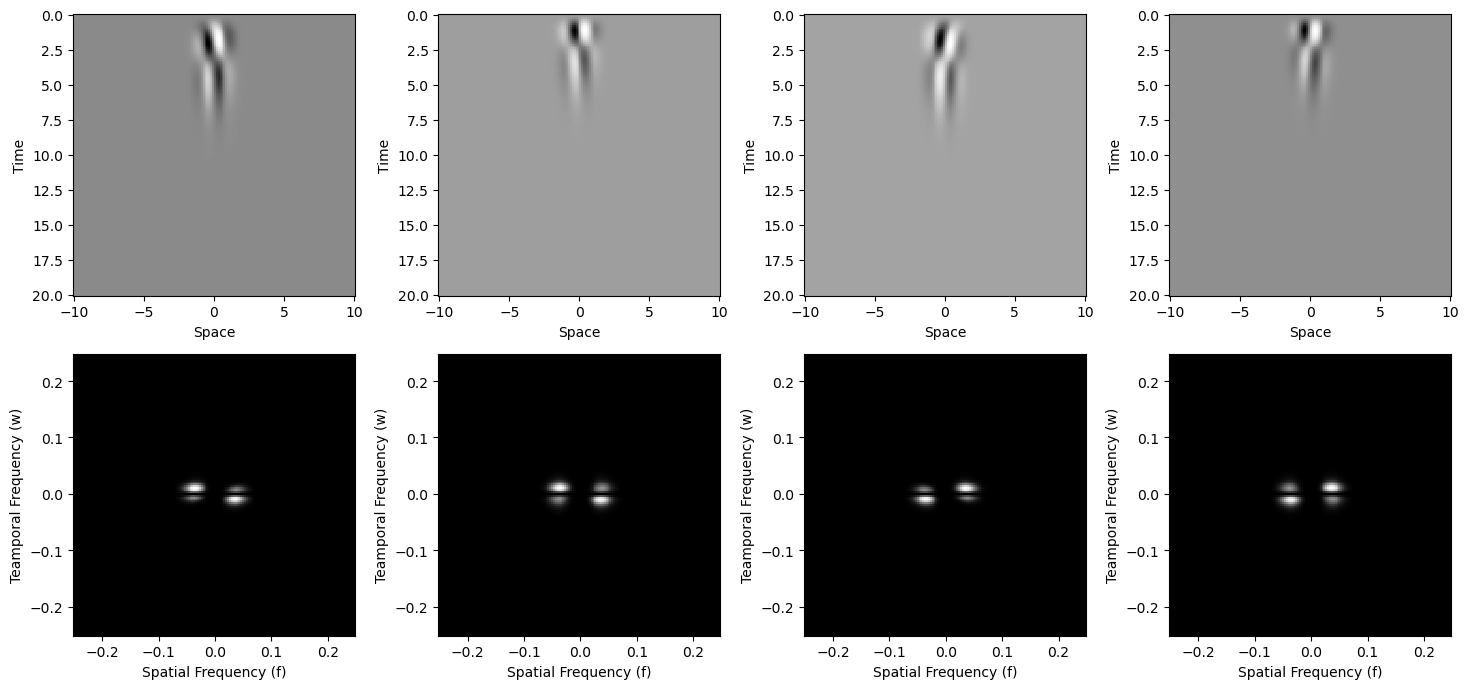

spatial Scale,  0.5
Temporal Scale:  4


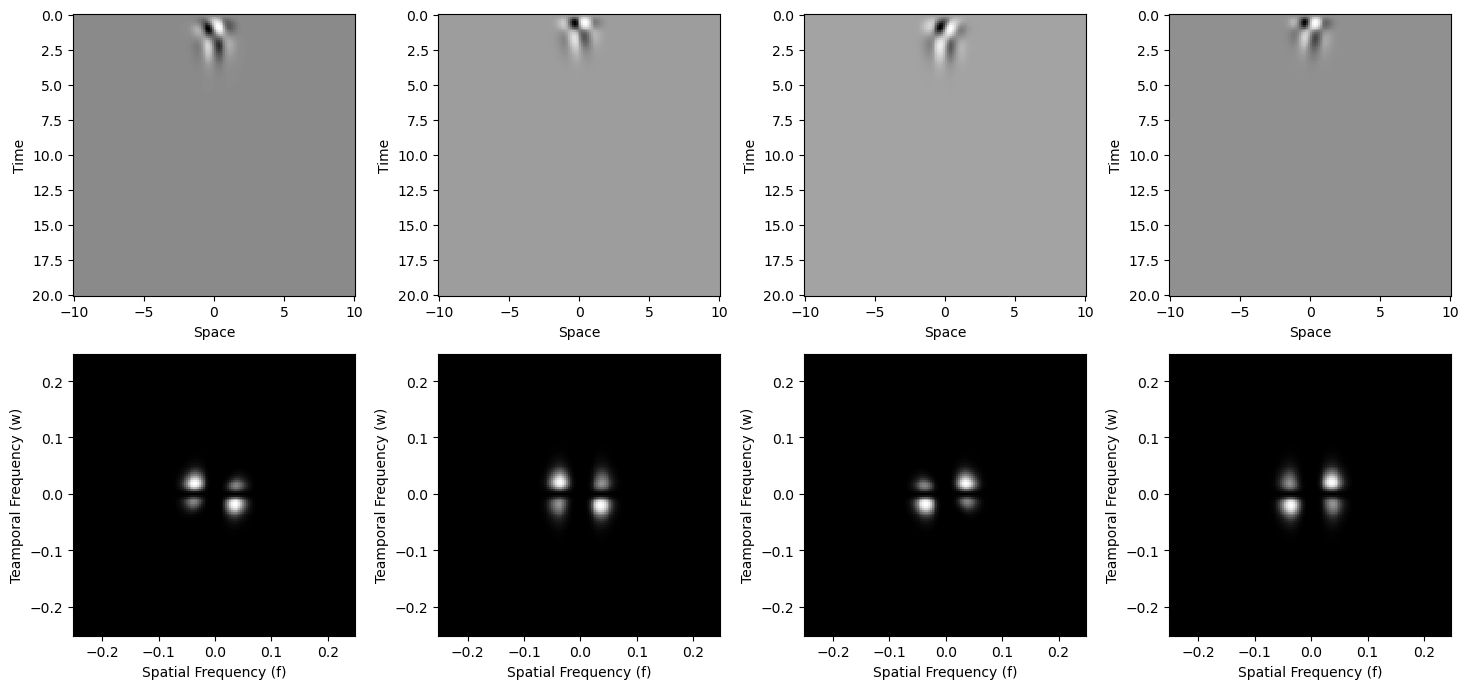

spatial Scale,  0.5
Temporal Scale:  8


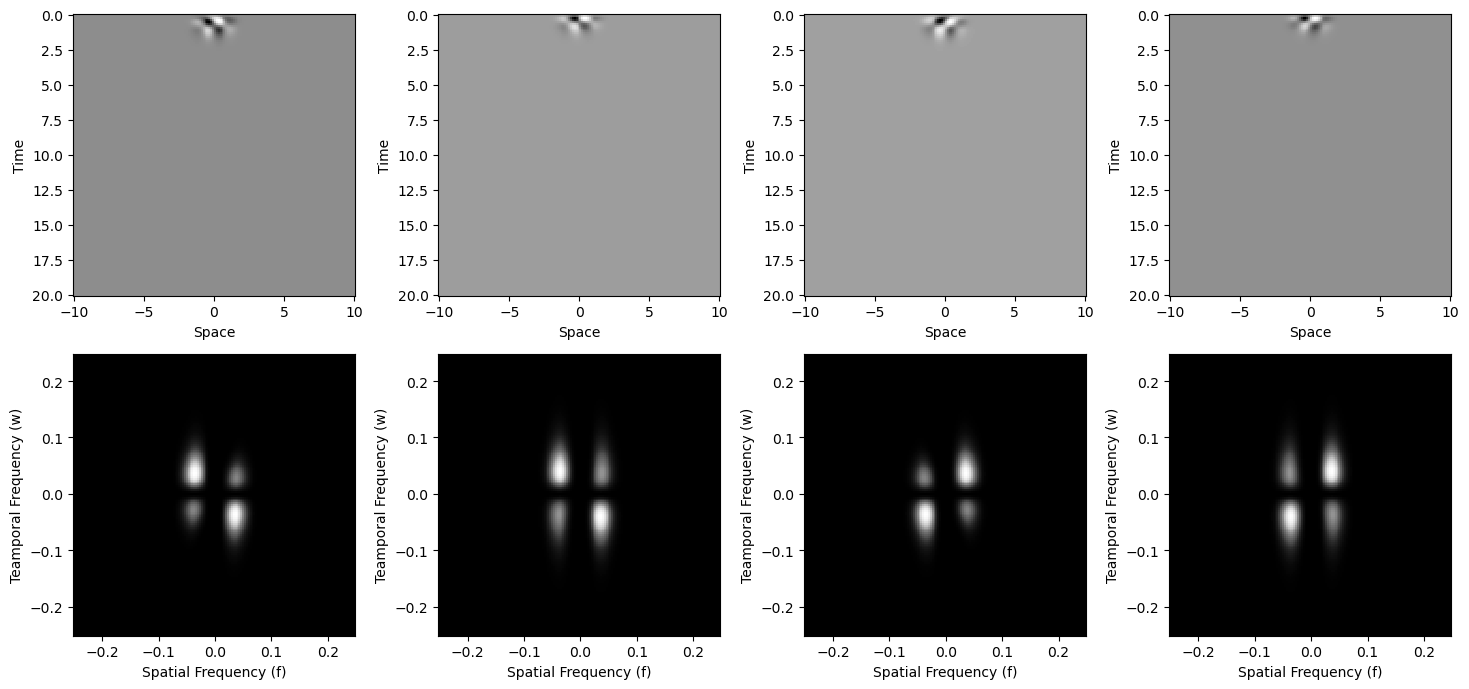

spatial Scale,  0.5
Temporal Scale:  16


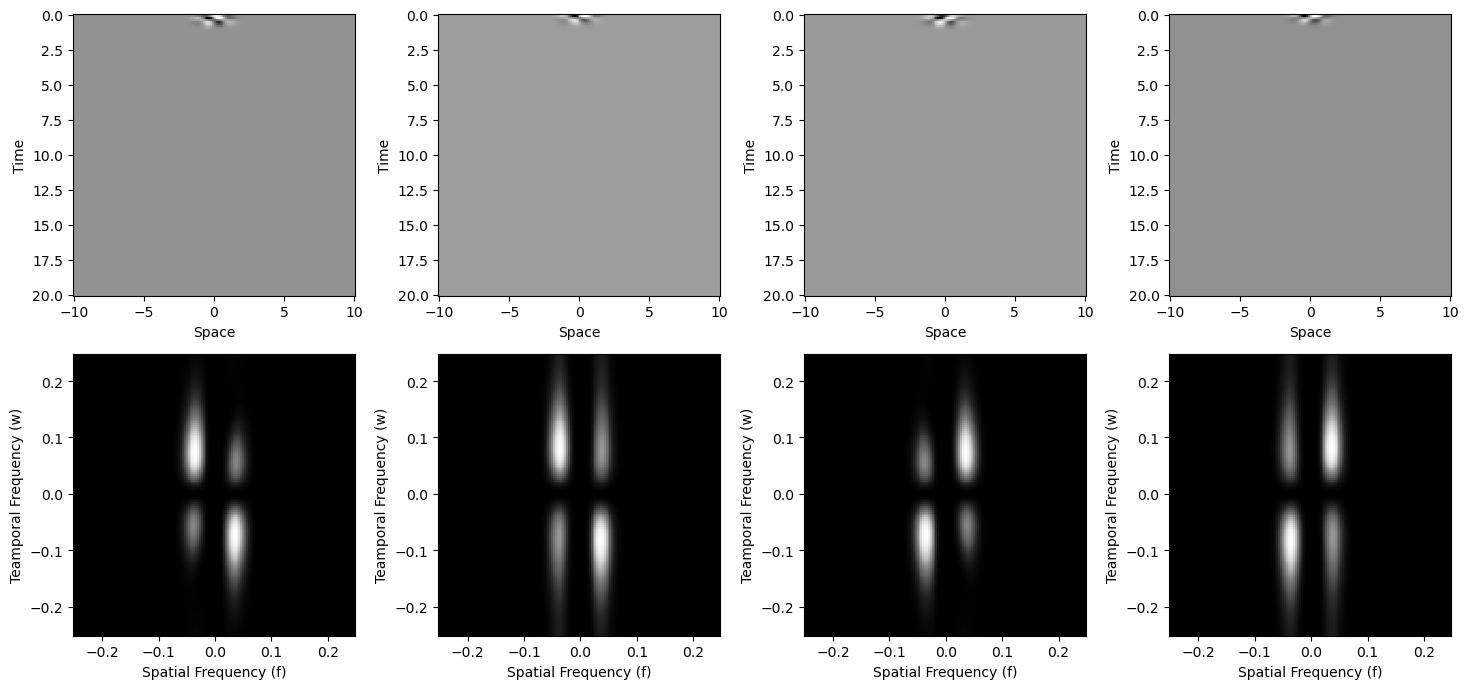

spatial Scale,  1
Temporal Scale:  2


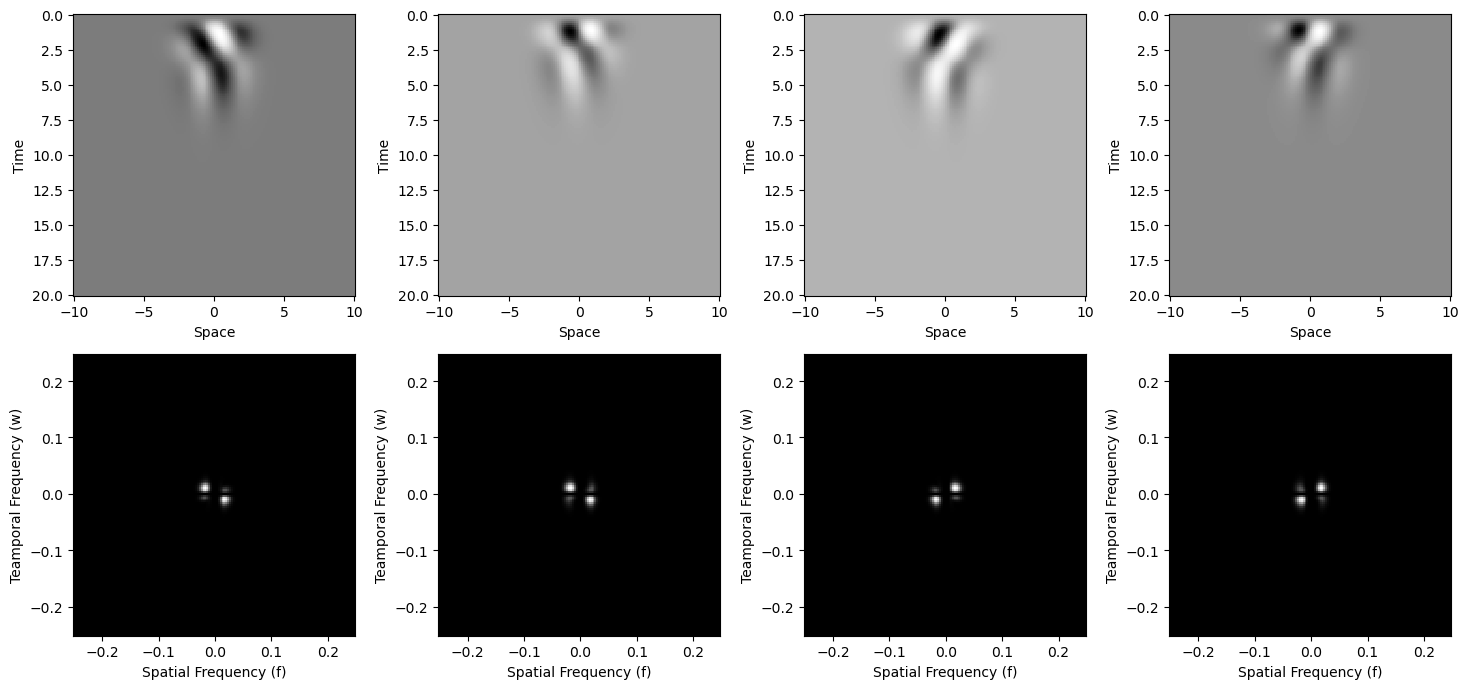

spatial Scale,  1
Temporal Scale:  4


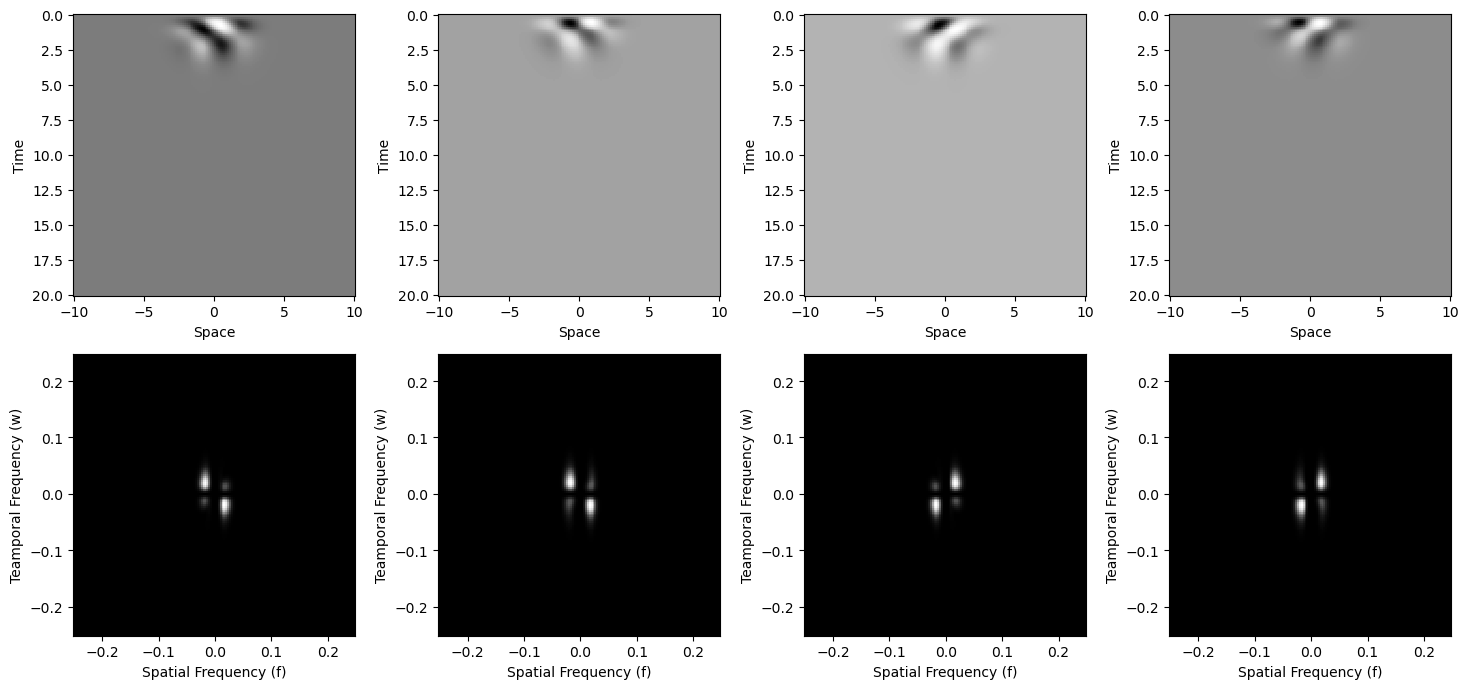

spatial Scale,  1
Temporal Scale:  8


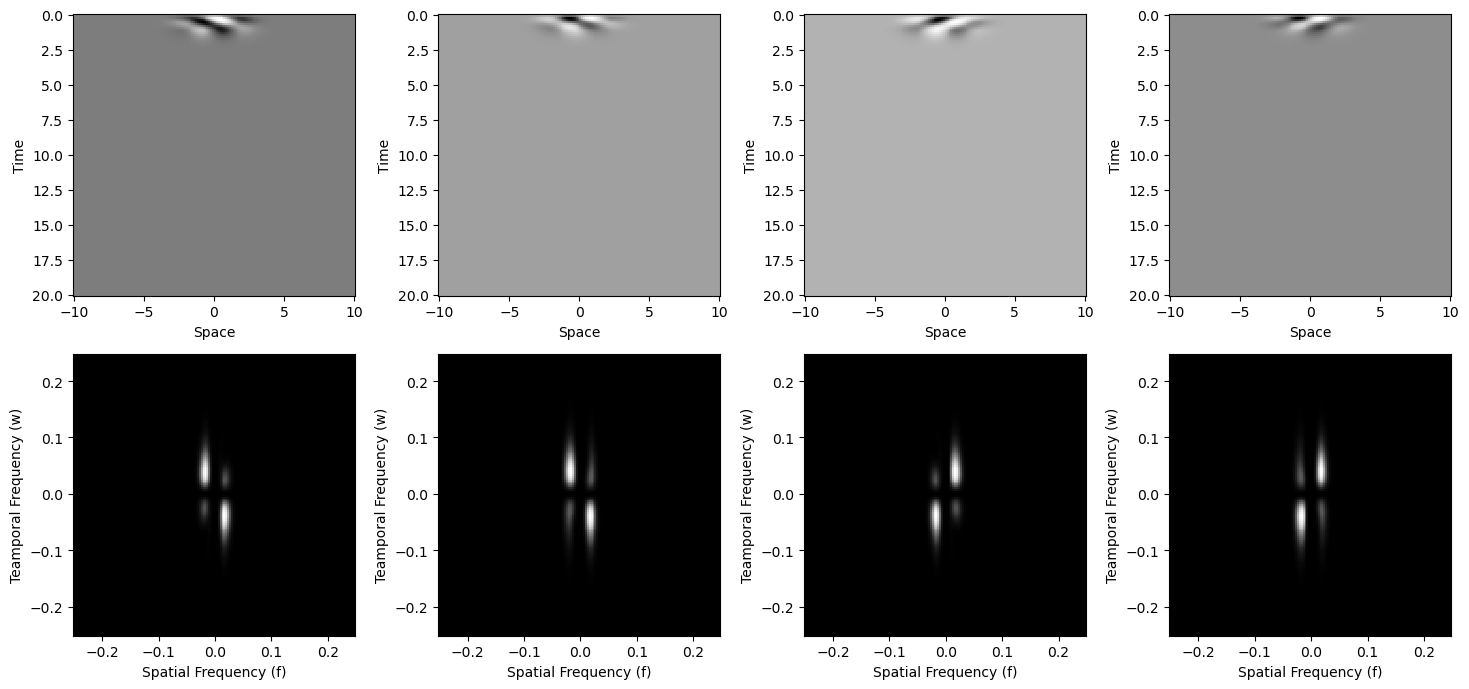

spatial Scale,  1
Temporal Scale:  16


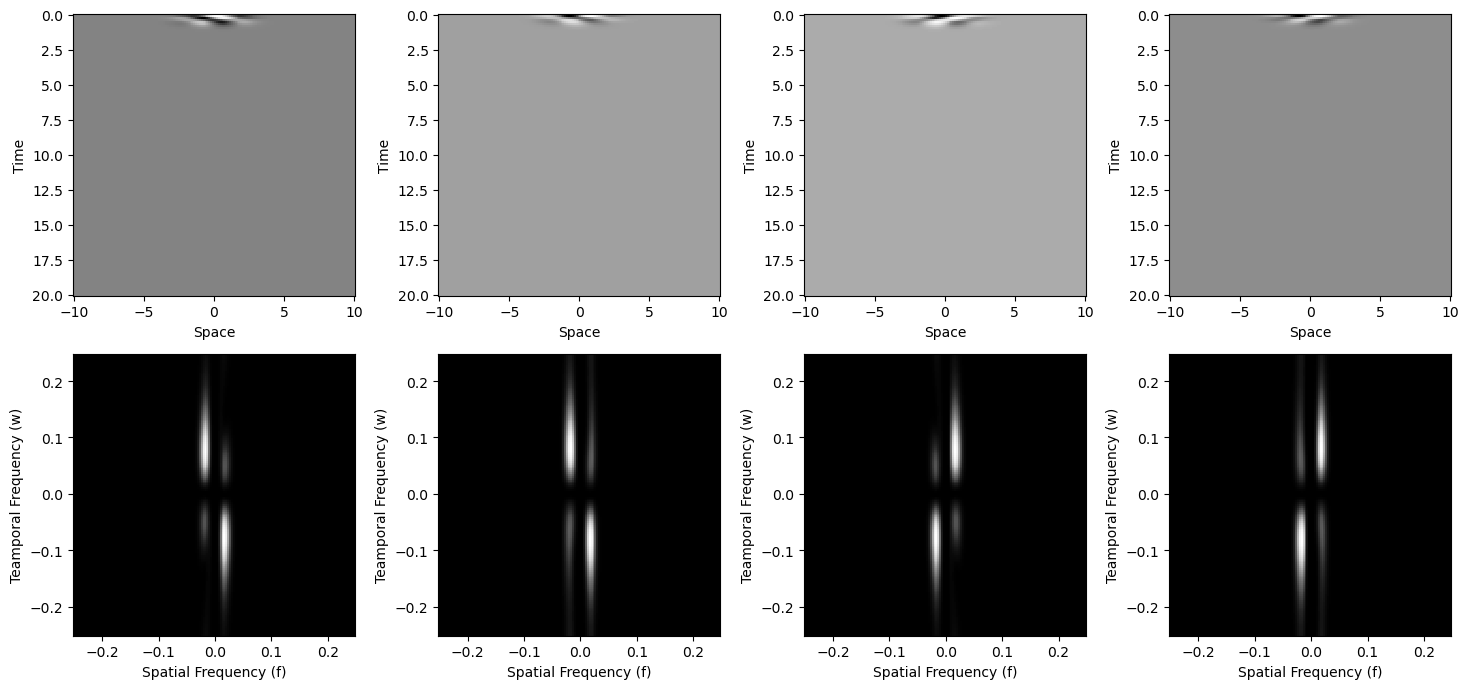

spatial Scale,  2
Temporal Scale:  2


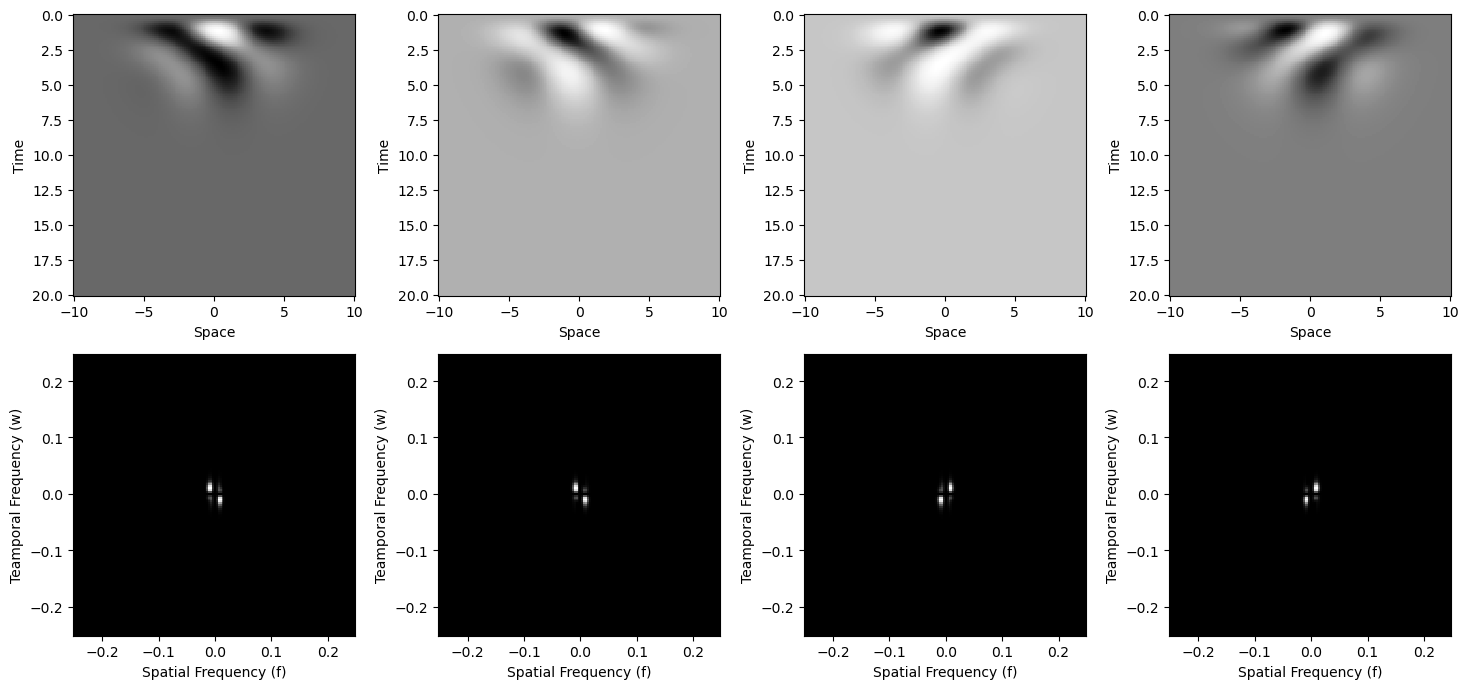

spatial Scale,  2
Temporal Scale:  4


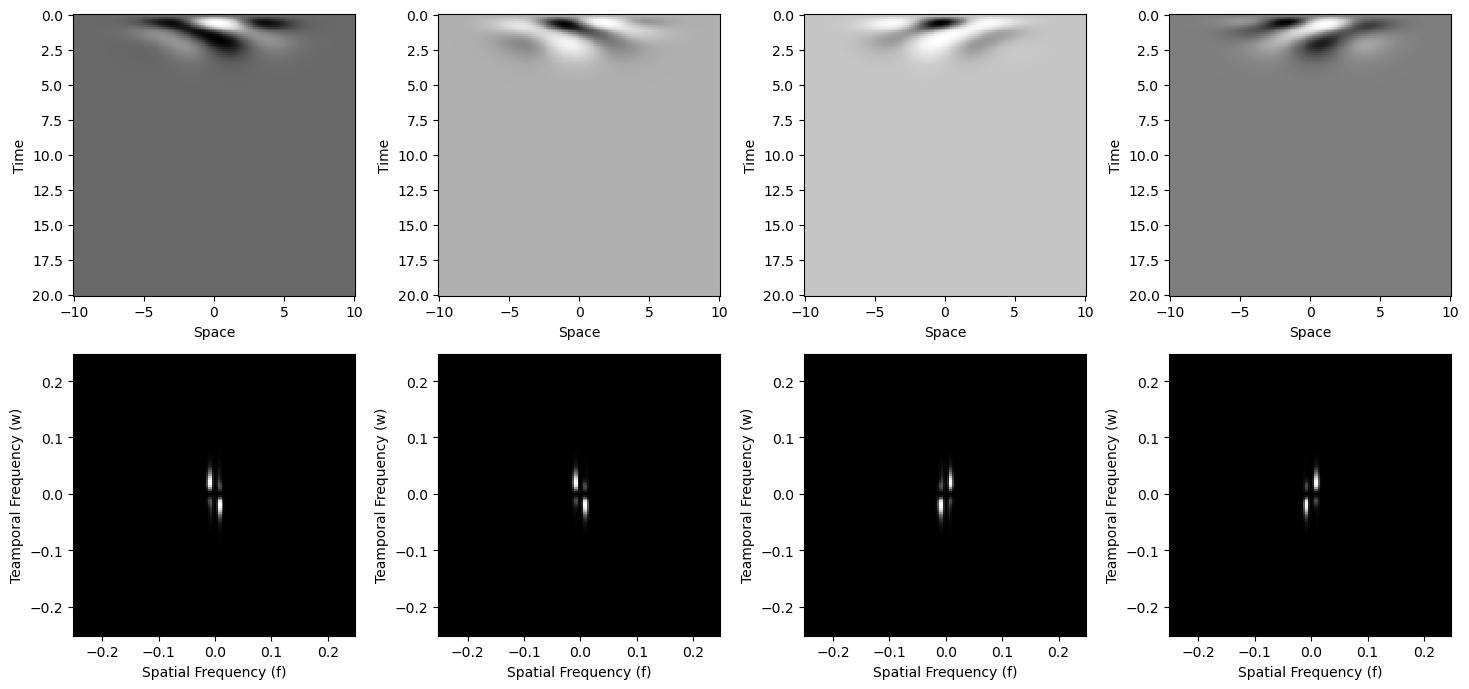

spatial Scale,  2
Temporal Scale:  8


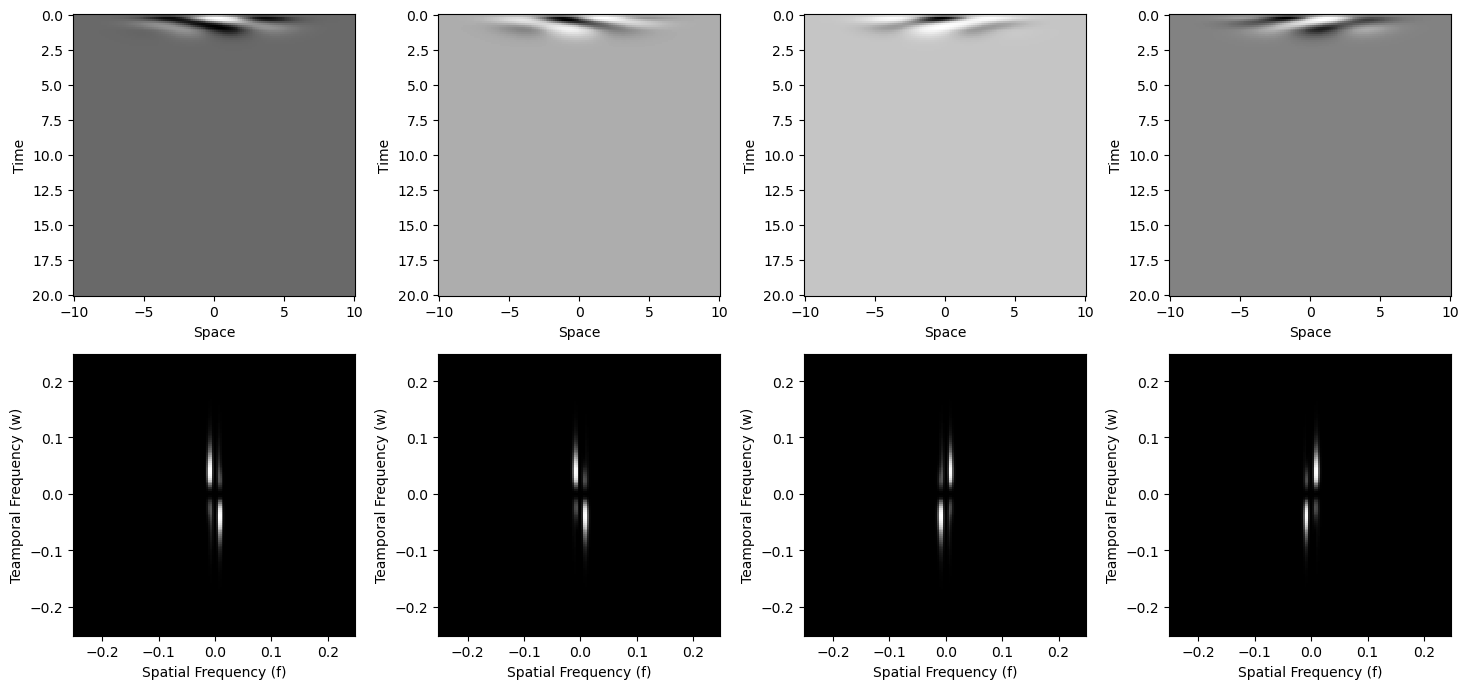

spatial Scale,  2
Temporal Scale:  16


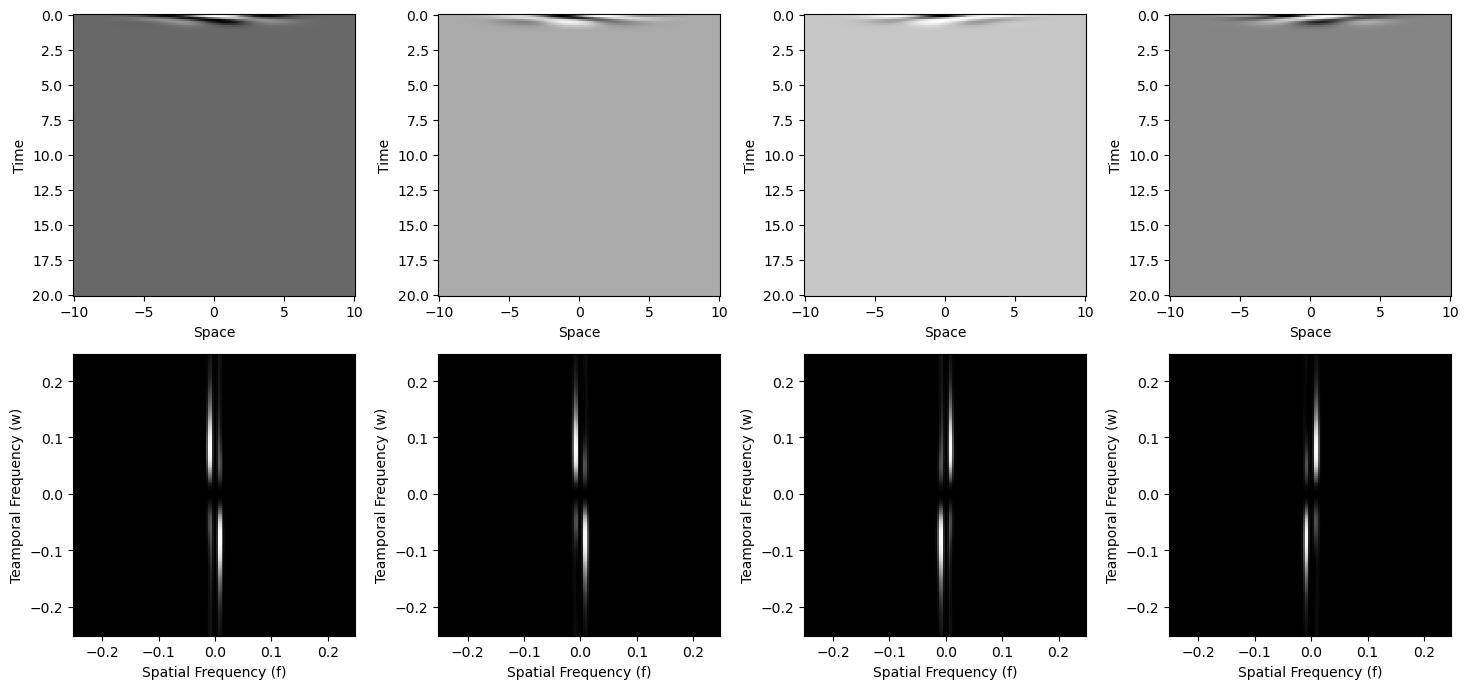

In [231]:
for spatial_scale in [0.25,0.5,1,2]:
    for temporal_scale in [2,4,8,16]:
        print('spatial Scale, ',spatial_scale)
        print("Temporal Scale: ",temporal_scale)
        
        #call our builder
        filters = build_4_filters(space,time,temporal_scale=temporal_scale,spatial_scale=spatial_scale)
        
        pspecs = [calc_power_spec(f)[0] for f in filters]
        _, fqspace, fqtime = calc_power_spec(filters[0])
        
        plt.figure(figsize=(15,7))
        
        for i in range(len(filters)):
            plt.subplot(2,len(filters),i+1, aspect=aspect_ratio)
            plt.pcolormesh(space, time, filters[i], shading='auto',cmap='Greys_r')
            plt.gca().invert_yaxis()
            plt.xlabel('Space')
            plt.ylabel('Time')
        
            plt.subplot(2,len(filters),i+1+len(filters), aspect=aspect_ratio)
            plt.pcolormesh(fqspace, fqtime, pspecs[i], shading='auto',cmap='Greys_r')
            plt.xlabel('Spatial Frequency (f)')
            plt.ylabel('Teamporal Frequency (w)')
            plt.tight_layout()
            
        plt.show()